In [1]:
import pandas as pd

# Chargement des donn√©es nettoy√©es
X_clean = pd.read_csv('X_clean.csv')
y = pd.read_csv('y.csv')

# V√©rification
print("‚úÖ Dimensions de X_clean :", X_clean.shape)
print("‚úÖ Dimensions de y :", y.shape)

/tmp/ipykernel_1541/3013409453.py:4: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  X_clean = pd.read_csv('X_clean.csv')


‚úÖ Dimensions de X_clean : (221210, 34)
‚úÖ Dimensions de y : (221210, 1)


√âtape suivante : Analyse exploratoire (EDA)

1_ Analyse de corr√©lation pour les variables quantitatives
Ô∏è2_ Visualisation avec une Heatmap
3_ Analyse des relations avec la cible (nutrition_grade_fr)

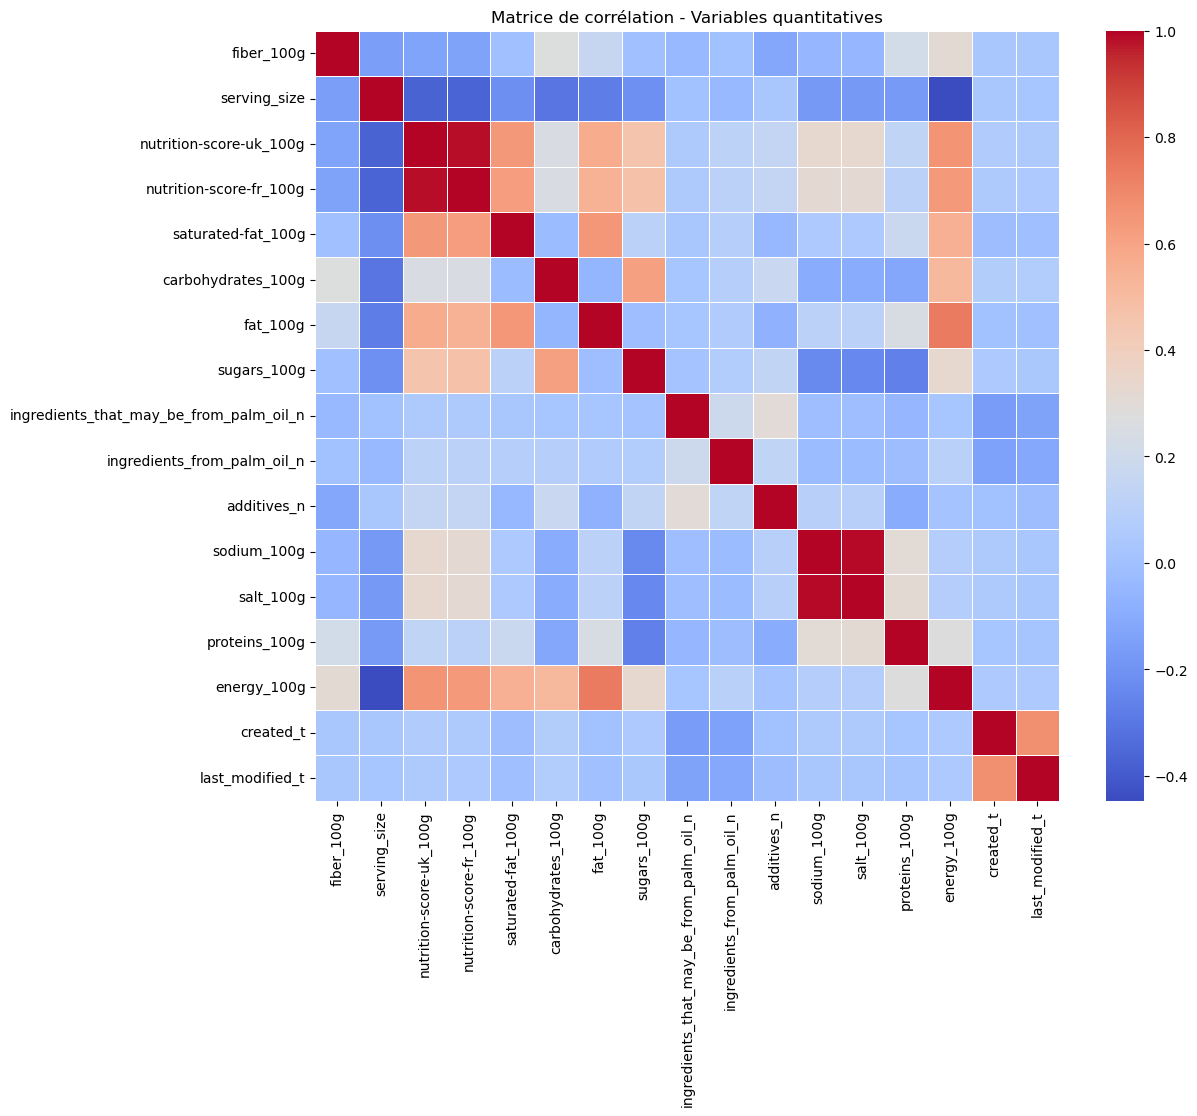

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

# S√©lectionner uniquement les variables num√©riques
quantitative_vars = X_clean.select_dtypes(include=['float64', 'int64'])

# Calcul de la matrice de corr√©lation
corr_matrix = quantitative_vars.corr()

# Taille de l'affichage
plt.figure(figsize=(12, 10))

# Heatmap
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Matrice de corr√©lation - Variables quantitatives')
plt.show()

Certaines variables sont fortement corr√©l√©es, ce qui peut cr√©er des redondances inutiles dans notre mod√®le.
L'objectif ici est d'optimiser notre dataset en r√©duisant le bruit tout en conservant l'information essentielle.
donc: 1_ R√©duire le bruit dans les donn√©es.
      2_ Optimiser le mod√®le en supprimant les redondances.
      3_ Conserver l'essentiel de l'information.

1_ sodium_100g peut √™tre supprim√© car il est presque une copie de salt_100g.
2_ saturated-fat_100g peut potentiellement √™tre supprim√© au profit de fat_100g (√† valider).
3_ ingredients_that_may_be_from_palm_oil_n peut √™tre fusionn√© avec ingredients_from_palm_oil_n.

Avant de supprimer, on va mesurer l'impact avec un test de corr√©lation plus pr√©cis.

In [3]:
import pandas as pd

# 1Ô∏è‚É£ V√©rification des corr√©lations (plus pr√©cises) :
print("üîé Corr√©lation entre sodium_100g et salt_100g :", X_clean[['sodium_100g', 'salt_100g']].corr())
print("üîé Corr√©lation entre saturated-fat_100g et fat_100g :", X_clean[['saturated-fat_100g', 'fat_100g']].corr())
print("üîé Corr√©lation entre ingredients_that_may_be_from_palm_oil_n et ingredients_from_palm_oil_n :", 
      X_clean[['ingredients_that_may_be_from_palm_oil_n', 'ingredients_from_palm_oil_n']].corr())

# 2Ô∏è‚É£ Suppression des variables redondantes si corr√©lation > 0.95
X_clean.drop(columns=['sodium_100g', 'ingredients_that_may_be_from_palm_oil_n'], inplace=True)

# 3Ô∏è‚É£ V√©rification
print("\n‚úÖ Dimensions apr√®s nettoyage :", X_clean.shape)

üîé Corr√©lation entre sodium_100g et salt_100g :              sodium_100g  salt_100g
sodium_100g     1.000000   0.992973
salt_100g       0.992973   1.000000
üîé Corr√©lation entre saturated-fat_100g et fat_100g :                     saturated-fat_100g  fat_100g
saturated-fat_100g            1.000000  0.646931
fat_100g                      0.646931  1.000000
üîé Corr√©lation entre ingredients_that_may_be_from_palm_oil_n et ingredients_from_palm_oil_n :                                          ingredients_that_may_be_from_palm_oil_n  \
ingredients_that_may_be_from_palm_oil_n                                 1.000000   
ingredients_from_palm_oil_n                                             0.190726   

                                         ingredients_from_palm_oil_n  
ingredients_that_may_be_from_palm_oil_n                     0.190726  
ingredients_from_palm_oil_n                                 1.000000  

‚úÖ Dimensions apr√®s nettoyage : (221210, 32)


Analyse d√©taill√©e :
1Ô∏è‚É£ sodium_100g ‚Üî salt_100g
Corr√©lation : 0.99, ce qui est quasiment parfait.
üëâ Cela montre que l'information est redondante. Sel (salt) est en grande partie constitu√© de sodium.
D√©cision : On pourrait envisager de supprimer l'un des deux pour √©viter la redondance, et le plus pertinent est souvent de conserver salt_100g car il est plus parlant pour l'utilisateur final.

2Ô∏è‚É£ saturated-fat_100g ‚Üî fat_100g
Corr√©lation : 0.64, ce qui est √©lev√©, mais pas totalement redondant.
üëâ Ici, on voit que les graisses satur√©es repr√©sentent une partie des graisses totales, mais pas √† 100 %. Il est int√©ressant de les conserver pour l'analyse, car elles n'apportent pas exactement la m√™me information.

3Ô∏è‚É£ ingredients_that_may_be_from_palm_oil_n ‚Üî ingredients_from_palm_oil_n
Corr√©lation : 0.19, donc tr√®s faible.
üëâ Cette relation n'est pas significative, on les garde s√©par√©ment car elles apportent des informations diff√©rentes.

ce que l'on va faire:
1_ Suppression de la colonne redondante :
On retire sodium_100g qui est corr√©l√© √† plus de 99% avec salt_100g.

2_ V√©rification des types :
On s'assure que tous les types de donn√©es sont corrects.

3_ Conversion explicite :
Si certaines colonnes ne sont pas au bon format (par exemple, des dates en texte), on les convertit.

4_ V√©rification des valeurs manquantes :
On v√©rifie qu'il n'y a pas de NaN apr√®s cette op√©ration.

5_ Sauvegarde dans un fichier CSV :
On enregistre le DataFrame final pour la prochaine √©tape d'analyse.

In [4]:
import pandas as pd

# 1Ô∏è‚É£ Suppression de la colonne redondante (si elle existe)
if 'sodium_100g' in X_clean.columns:
    print("üóëÔ∏è Suppression de la colonne redondante 'sodium_100g'...")
    X_clean.drop(columns=['sodium_100g'], inplace=True)
else:
    print("‚ö†Ô∏è La colonne 'sodium_100g' n'existe pas dans le DataFrame.")

# 2Ô∏è‚É£ V√©rification des types de donn√©es
print("\nüîé V√©rification des types de donn√©es apr√®s nettoyage :")
print(X_clean.dtypes)

# 3Ô∏è‚É£ Conversion explicite si n√©cessaire
print("\nüîÑ Conversion explicite si n√©cessaire...")
# Par exemple, si certaines colonnes doivent √™tre en int ou float, on peut le faire ici.
colonnes_a_convertir = ['created_t', 'last_modified_t']
X_clean[colonnes_a_convertir] = X_clean[colonnes_a_convertir].apply(pd.to_numeric, errors='coerce')

# 4Ô∏è‚É£ V√©rification finale des valeurs manquantes
print("\nüìå V√©rification des valeurs manquantes :")
print(X_clean.isnull().sum())

# 5Ô∏è‚É£ Sauvegarde dans un fichier CSV
print("\nüíæ Sauvegarde du DataFrame nettoy√© dans 'X_clean_final.csv'")
X_clean.to_csv('X_clean_final.csv', index=False)

print("\n‚úÖ Le fichier 'X_clean_final.csv' a √©t√© sauvegard√© avec succ√®s.")

‚ö†Ô∏è La colonne 'sodium_100g' n'existe pas dans le DataFrame.

üîé V√©rification des types de donn√©es apr√®s nettoyage :
fiber_100g                     float64
serving_size                   float64
nutrition-score-uk_100g        float64
nutrition-score-fr_100g        float64
saturated-fat_100g             float64
carbohydrates_100g             float64
fat_100g                       float64
sugars_100g                    float64
additives                       object
ingredients_from_palm_oil_n    float64
additives_n                    float64
ingredients_text                object
salt_100g                      float64
proteins_100g                  float64
energy_100g                    float64
brands_tags                     object
brands                          object
product_name                    object
countries_fr                    object
countries_tags                  object
countries                       object
states_fr                       object
states           

R√©capitulatif:

1_ Nettoyage des colonnes redondantes (sodium_100g a bien √©t√© supprim√©e).

2_ V√©rification des types de donn√©es ‚Äî tout est en ordre, pas de types incoh√©rents.

3_ Absence de valeurs manquantes ‚Äî nous avons un dataset propre.

4_ Sauvegarde du DataFrame ‚Äî le fichier X_clean_final.csv est pr√™t.

v√©rification:

In [5]:
import pandas as pd

# Chargement du DataFrame propre
X_clean = pd.read_csv('X_clean_final.csv')

# 1Ô∏è‚É£ Affichage des dimensions
print(f"‚úÖ Dimensions du dataset : {X_clean.shape}")

# 2Ô∏è‚É£ Aper√ßu des premi√®res lignes
print("\nüîé Aper√ßu des premi√®res lignes :")
display(X_clean.head())

# 3Ô∏è‚É£ Information globale sur le dataset
print("\nüìå Aper√ßu global des donn√©es :")
X_clean.info()

# 4Ô∏è‚É£ Statistiques descriptives globales
print("\nüìä Statistiques descriptives (variables quantitatives) :")
display(X_clean.describe().T)

print("\nüìä Statistiques descriptives (variables qualitatives) :")
display(X_clean.describe(include=['object']).T)

# 5Ô∏è‚É£ V√©rification des valeurs manquantes
print("\n‚ùì V√©rification des valeurs manquantes :")
missing_values = X_clean.isnull().sum()
missing_percent = (missing_values / len(X_clean)) * 100
missing_report = pd.DataFrame({
    'Valeurs manquantes': missing_values,
    'Pourcentage (%)': missing_percent
}).sort_values(by='Valeurs manquantes', ascending=False)

# Afficher le rapport uniquement pour les colonnes contenant des NaN
display(missing_report[missing_report['Valeurs manquantes'] > 0])

# 6Ô∏è‚É£ V√©rification des doublons
print("\nüîé V√©rification des doublons :")
nb_duplicated = X_clean.duplicated().sum()
print(f"Nombre de doublons d√©tect√©s : {nb_duplicated}")

if nb_duplicated > 0:
    print("\n‚ö†Ô∏è Attention : des doublons sont pr√©sents dans le dataset.")
else:
    print("\n‚úÖ Aucune ligne en doublon d√©tect√©e.")

/tmp/ipykernel_1541/1590734266.py:4: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  X_clean = pd.read_csv('X_clean_final.csv')


‚úÖ Dimensions du dataset : (221210, 32)

üîé Aper√ßu des premi√®res lignes :


fiber_100g  serving_size  nutrition-score-uk_100g  nutrition-score-fr_100g  \
0         3.6          28.0                     14.0                     14.0   
1         7.1          28.0                      0.0                      0.0   
2         7.1          28.0                     12.0                     12.0   
3         9.4          64.0                      7.0                      7.0   
4         6.7          30.0                     12.0                     12.0   

   saturated-fat_100g  carbohydrates_100g  fat_100g  sugars_100g  \
0               28.57               64.29     28.57        14.29   
1                0.00               60.71     17.86        17.86   
2                5.36               17.86     57.14         3.57   
3                4.69               57.81     18.75        15.62   
4                5.00               36.67     36.67         3.33   

                                           additives  \
0   [ bananas -> en:bananas  ]  [ vegetable-oil -...   
1   [ peanuts -> en:peanuts  ]  [ wheat-flour -> ...   
2   [ organic-hazelnuts -> en:organic-hazelnuts  ...   
3   [ org-oats -> en:org-oats  ]  [ oats -> en:oa...   
4   [ roasted-peanuts -> en:roasted-peanuts  ]  [...   

   ingredients_from_palm_oil_n  ...  \
0                          0.0  ...   
1                          0.0  ...   
2                          0.0  ...   
3                          0.0  ...   
4                          0.0  ...   

                                              states  \
0  en:to-be-completed, en:nutrition-facts-complet...   
1  en:to-be-completed, en:nutrition-facts-complet...   
2  en:to-be-completed, en:nutrition-facts-complet...   
3  en:to-be-completed, en:nutrition-facts-complet...   
4  en:to-be-completed, en:nutrition-facts-complet...   

                                         states_tags   code  \
0  en:to-be-completed,en:nutrition-facts-complete...   4530   
1  en:to-be-completed,en:nutrition-facts-complete...   4559   
2  en:to-be-completed,en:nutrition-facts-complete...  16087   
3  en:to-be-completed,en:nutrition-facts-complete...  16124   
4  en:to-be-completed,en:nutrition-facts-complete...  16872   

                                                 url      created_datetime  \
0  http://world-fr.openfoodfacts.org/produit/0000...  2017-03-09T14:32:37Z   
1  http://world-fr.openfoodfacts.org/produit/0000...  2017-03-09T14:32:37Z   
2  http://world-fr.openfoodfacts.org/produit/0000...  2017-03-09T10:35:31Z   
3  http://world-fr.openfoodfacts.org/produit/0000...  2017-03-09T10:35:11Z   
4  http://world-fr.openfoodfacts.org/produit/0000...  2017-03-09T10:34:10Z   

    created_t          creator last_modified_t last_modified_datetime  \
0  1489069957  usda-ndb-import      1489069957   2017-03-09T14:32:37Z   
1  1489069957  usda-ndb-import      1489069957   2017-03-09T14:32:37Z   
2  1489055731  usda-ndb-import      1489055731   2017-03-09T10:35:31Z   
3  1489055711  usda-ndb-import      1489055712   2017-03-09T10:35:12Z   
4  1489055650  usda-ndb-import      1489055651   2017-03-09T10:34:11Z   

  nutrition_grade_fr  
0                  d  
1                  b  
2                  d  
3                  c  
4                  d  

[5 rows x 32 columns]


üìå Aper√ßu global des donn√©es :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221210 entries, 0 to 221209
Data columns (total 32 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   fiber_100g                   221210 non-null  float64
 1   serving_size                 221210 non-null  float64
 2   nutrition-score-uk_100g      221210 non-null  float64
 3   nutrition-score-fr_100g      221210 non-null  float64
 4   saturated-fat_100g           221210 non-null  float64
 5   carbohydrates_100g           221210 non-null  float64
 6   fat_100g                     221210 non-null  float64
 7   sugars_100g                  221210 non-null  float64
 8   additives                    221210 non-null  object 
 9   ingredients_from_palm_oil_n  221210 non-null  float64
 10  additives_n                  221210 non-null  float64
 11  ingredients_text             221210 non-null  object 
 12  salt_100g             

count          mean           std  \
fiber_100g                   221210.0  2.500797e+00  3.464248e+00   
serving_size                 221210.0  6.362084e+01  6.781083e+01   
nutrition-score-uk_100g      221210.0  9.058049e+00  9.183589e+00   
nutrition-score-fr_100g      221210.0  9.165535e+00  9.055903e+00   
saturated-fat_100g           221210.0  4.967372e+00  7.657164e+00   
carbohydrates_100g           221210.0  3.249851e+01  2.729006e+01   
fat_100g                     221210.0  1.286931e+01  1.555234e+01   
sugars_100g                  221210.0  1.499628e+01  1.981209e+01   
ingredients_from_palm_oil_n  221210.0  1.939786e-02  1.395483e-01   
additives_n                  221210.0  1.757737e+00  2.460734e+00   
salt_100g                    221210.0  9.254195e-01  1.138097e+00   
proteins_100g                221210.0  7.752599e+00  7.974949e+00   
energy_100g                  221210.0  1.176480e+03  7.603751e+02   
created_t                    221210.0  1.473993e+09  3.145588e+07   
last_modified_t              221210.0  1.482270e+09  1.747113e+07   

                                      min           25%           50%  \
fiber_100g                   0.000000e+00  0.000000e+00  1.500000e+00   
serving_size                 0.000000e+00  2.800000e+01  3.000000e+01   
nutrition-score-uk_100g     -1.500000e+01  1.000000e+00  9.000000e+00   
nutrition-score-fr_100g     -1.500000e+01  1.000000e+00  1.000000e+01   
saturated-fat_100g           0.000000e+00  0.000000e+00  1.790000e+00   
carbohydrates_100g           0.000000e+00  7.960000e+00  2.400000e+01   
fat_100g                     0.000000e+00  1.170000e+00  7.140000e+00   
sugars_100g                  0.000000e+00  1.300000e+00  5.000000e+00   
ingredients_from_palm_oil_n  0.000000e+00  0.000000e+00  0.000000e+00   
additives_n                  0.000000e+00  0.000000e+00  1.000000e+00   
salt_100g                    0.000000e+00  1.000000e-01  6.350000e-01   
proteins_100g                0.000000e+00  1.900000e+00  5.700000e+00   
energy_100g                  0.000000e+00  4.520000e+02  1.192000e+03   
created_t                    0.000000e+00  1.478335e+09  1.489064e+09   
last_modified_t              1.333873e+09  1.487273e+09  1.489067e+09   

                                      75%           max  
fiber_100g                   3.300000e+00  3.000000e+01  
serving_size                 7.600000e+01  5.000000e+02  
nutrition-score-uk_100g      1.600000e+01  4.000000e+01  
nutrition-score-fr_100g      1.600000e+01  4.000000e+01  
saturated-fat_100g           7.140000e+00  5.500000e+02  
carbohydrates_100g           5.714000e+01  2.093800e+02  
fat_100g                     2.000000e+01  1.000000e+02  
sugars_100g                  2.301750e+01  1.000000e+02  
ingredients_from_palm_oil_n  0.000000e+00  2.000000e+00  
additives_n                  3.000000e+00  3.100000e+01  
salt_100g                    1.300480e+00  1.000000e+01  
proteins_100g                1.071000e+01  8.000000e+01  
energy_100g                  1.715000e+03  4.000000e+03  
created_t                    1.489091e+09  1.492723e+09  
last_modified_t              1.489095e+09  1.492736e+09


üìä Statistiques descriptives (variables qualitatives) :


count  unique  \
additives               221210  158780   
ingredients_text        221210  165584   
brands_tags             221210   35110   
brands                  221210   40103   
product_name            221210  160544   
countries_fr            221210     501   
countries_tags          221210     501   
countries               221210     896   
states_fr               221210     512   
states                  221210     512   
states_tags             221210     512   
code                    221210  221128   
url                     221210  221210   
created_datetime        221210  122480   
creator                 221210    2366   
last_modified_datetime  221210  116753   
nutrition_grade_fr      221210       5   

                                                                      top  \
additives                                     [ almonds -> en:almonds  ]    
ingredients_text                                                 Almonds.   
brands_tags                                                     carrefour   
brands                                                          Carrefour   
product_name                                                    Ice Cream   
countries_fr                                                   √âtats-Unis   
countries_tags                                           en:united-states   
countries                                                              US   
states_fr               A compl√©ter,Informations nutritionnelles compl...   
states                  en:to-be-completed, en:nutrition-facts-complet...   
states_tags             en:to-be-completed,en:nutrition-facts-complete...   
code                                                          75925301020   
url                     http://world-fr.openfoodfacts.org/produit/9956...   
created_datetime                                     2017-03-09T10:37:09Z   
creator                                                   usda-ndb-import   
last_modified_datetime                               2015-08-09T17:35:49Z   
nutrition_grade_fr                                                      d   

                          freq  
additives                25321  
ingredients_text         25246  
brands_tags               7058  
brands                    7012  
product_name              3156  
countries_fr            139154  
countries_tags          139154  
countries               137643  
states_fr               136816  
states                  136816  
states_tags             136816  
code                         2  
url                          1  
created_datetime            20  
creator                 137616  
last_modified_datetime      23  
nutrition_grade_fr       62763


‚ùì V√©rification des valeurs manquantes :


Empty DataFrame
Columns: [Valeurs manquantes, Pourcentage (%)]
Index: []


üîé V√©rification des doublons :
Nombre de doublons d√©tect√©s : 0

‚úÖ Aucune ligne en doublon d√©tect√©e.


Analyse Univari√©e : Exploration des Variables

L'objectif de l'analyse univari√©e est de comprendre la distribution, les tendances, et les valeurs atypiques (outliers) de chaque variable, qu'elle soit quantitative (nombres) ou qualitative (cat√©gories).

√âtape 1 : Analyse des variables quantitatives

/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na opti

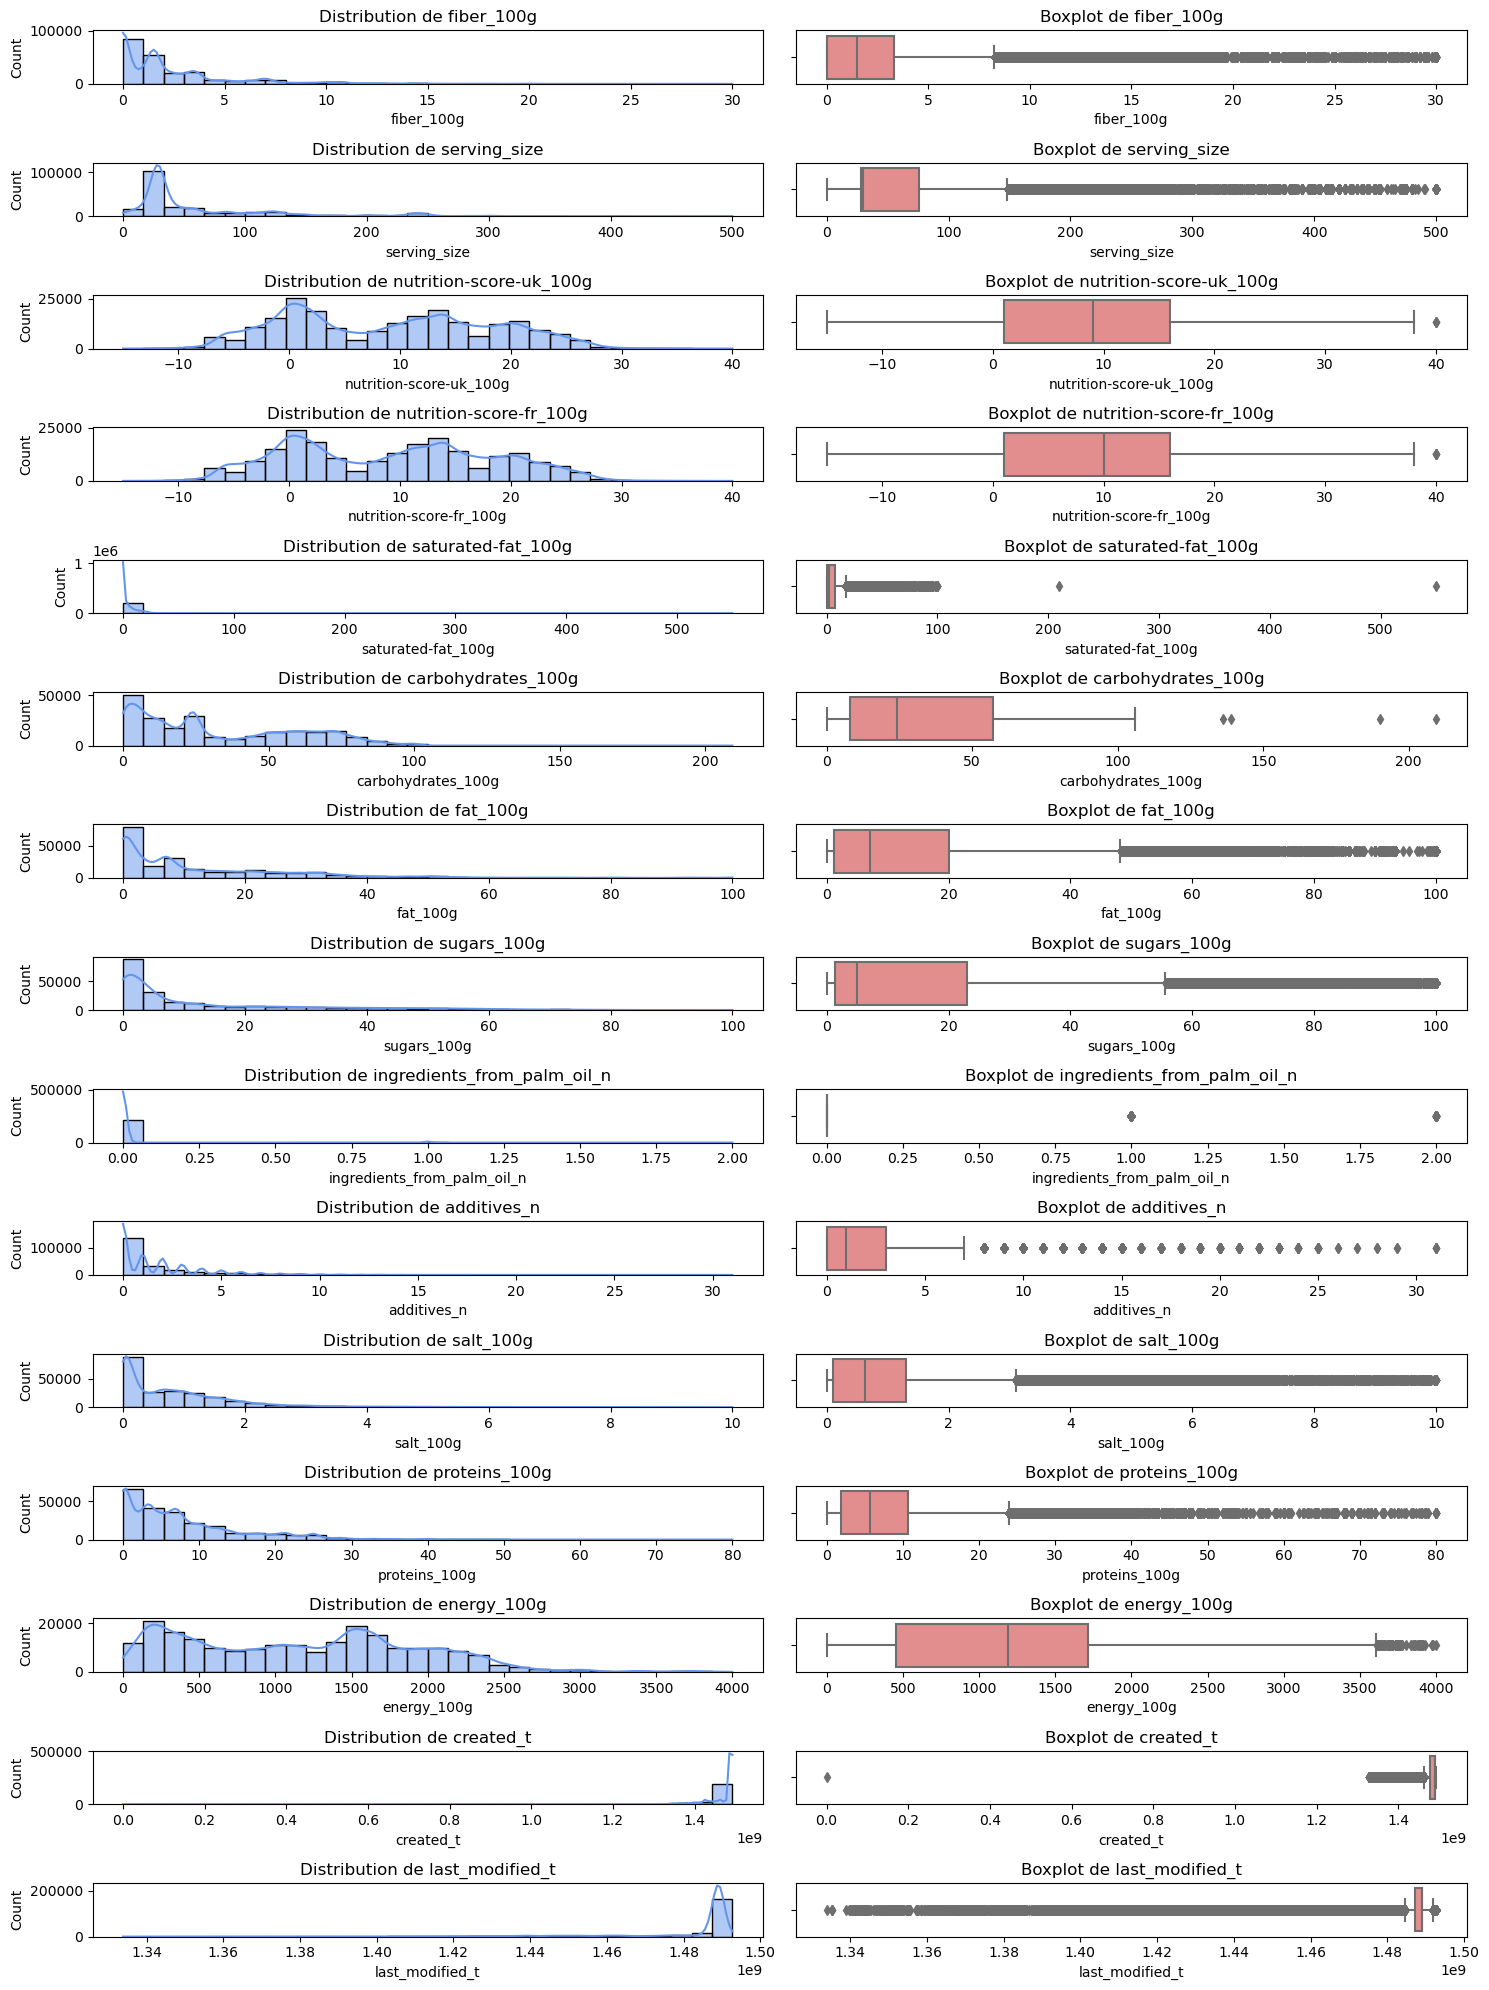

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# S√©lection des variables quantitatives
quantitative_vars = X_clean.select_dtypes(include=['float64', 'int64']).columns

# Taille de la figure
plt.figure(figsize=(15, 20))

# Boucle sur chaque variable pour g√©n√©rer l'histogramme et le boxplot
for idx, var in enumerate(quantitative_vars):
    plt.subplot(len(quantitative_vars), 2, idx * 2 + 1)
    sns.histplot(X_clean[var], bins=30, kde=True, color='cornflowerblue')
    plt.title(f'Distribution de {var}')
    
    plt.subplot(len(quantitative_vars), 2, idx * 2 + 2)
    sns.boxplot(x=X_clean[var], color='lightcoral')
    plt.title(f'Boxplot de {var}')

plt.tight_layout()
plt.show()

Les groupes de corr√©lation montrent des logiques nutritionnelles : graisses vs graisses satur√©es, glucides vs sucres, sel vs sodium.

Certains indicateurs sont presque redondants, ce qui pourrait permettre une simplification des variables pour √©viter les doublons.

Les scores nutritionnels FR et UK partagent des facteurs communs, ce qui permettrait d'unifier certaines √©tapes d'analyse.

Conclusion :
Cette matrice de corr√©lation nous permet de visualiser clairement les relations entre les diff√©rentes variables quantitatives. Les fortes corr√©lations d√©tect√©es sugg√®rent qu'un nettoyage pourrait √™tre envisag√© pour √©viter la redondance, tout en maintenant l'information cruciale. Une √©tude plus pouss√©e sur les variables influen√ßant directement les scores nutritionnels pourrait √©galement optimiser les pr√©dictions.

Plan d'action :
Supprimer les redondances :

D√©cider si on garde ou non les variables en double.

Transformer en ratio si cela a du sens (ex: sugars_100g / carbohydrates_100g).

V√©rification de la normalisation :

On regarde les distributions apr√®s cette transformation.

Recalculer la matrice de corr√©lation pour observer les changements.

In [7]:
import pandas as pd

# 1Ô∏è‚É£ Chargement du DataFrame propre
X_clean = pd.read_csv('X_clean_final.csv')

# 2Ô∏è‚É£ Suppression des redondances identifi√©es (si elles existent encore)
print("üóëÔ∏è Suppression des redondances...")
colonnes_a_supprimer = ['ingredients_that_may_be_from_palm_oil_n']

# V√©rification de l'existence des colonnes avant suppression
colonnes_existe = [col for col in colonnes_a_supprimer if col in X_clean.columns]

if colonnes_existe:
    X_clean.drop(columns=colonnes_existe, inplace=True)
    print(f"‚úÖ Colonnes supprim√©es : {colonnes_existe}")
else:
    print("‚ö†Ô∏è Aucune colonne √† supprimer trouv√©e.")

# 3Ô∏è‚É£ Cr√©ation de nouveaux ratios
print("\nüîÑ Cr√©ation de ratios :")
X_clean['sugars_ratio'] = X_clean['sugars_100g'] / X_clean['carbohydrates_100g']
X_clean['saturated_fat_ratio'] = X_clean['saturated-fat_100g'] / X_clean['fat_100g']

# Remplacer les NaN et les infinis par 0 (car si glucides ou gras = 0, le ratio n'a pas de sens)
X_clean['sugars_ratio'].replace([float('inf'), -float('inf')], 0, inplace=True)
X_clean['sugars_ratio'].fillna(0, inplace=True)

X_clean['saturated_fat_ratio'].replace([float('inf'), -float('inf')], 0, inplace=True)
X_clean['saturated_fat_ratio'].fillna(0, inplace=True)

print("‚úÖ Ratios cr√©√©s : 'sugars_ratio' et 'saturated_fat_ratio'")

# 4Ô∏è‚É£ V√©rification des types de donn√©es et des valeurs manquantes
print("\nüîé V√©rification des types de donn√©es apr√®s transformation :")
print(X_clean.dtypes)

print("\nüìå V√©rification des valeurs manquantes :")
print(X_clean.isnull().sum())

# 5Ô∏è‚É£ Sauvegarde du nouveau DataFrame propre
X_clean.to_csv('X_clean_transformed.csv', index=False)
print("\nüíæ Sauvegarde du DataFrame transform√© dans 'X_clean_transformed.csv' r√©ussie !")

/tmp/ipykernel_1541/3035964052.py:4: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  X_clean = pd.read_csv('X_clean_final.csv')


üóëÔ∏è Suppression des redondances...
‚ö†Ô∏è Aucune colonne √† supprimer trouv√©e.

üîÑ Cr√©ation de ratios :
‚úÖ Ratios cr√©√©s : 'sugars_ratio' et 'saturated_fat_ratio'

üîé V√©rification des types de donn√©es apr√®s transformation :
fiber_100g                     float64
serving_size                   float64
nutrition-score-uk_100g        float64
nutrition-score-fr_100g        float64
saturated-fat_100g             float64
carbohydrates_100g             float64
fat_100g                       float64
sugars_100g                    float64
additives                       object
ingredients_from_palm_oil_n    float64
additives_n                    float64
ingredients_text                object
salt_100g                      float64
proteins_100g                  float64
energy_100g                    float64
brands_tags                     object
brands                          object
product_name                    object
countries_fr                    object
countries_tags      

Les redondances ont √©t√© trait√©es et les nouveaux ratios ont √©t√© cr√©√©s.

Visualisation et Analyse des Ratios

Visualiser la distribution des nouveaux ratios (sugars_ratio et saturated_fat_ratio).

V√©rifier s'il y a des valeurs extr√™mes ou aberrantes.

Comparer ces ratios en fonction du nutrition_grade_fr.

/tmp/ipykernel_1541/3538566695.py:6: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  X_clean = pd.read_csv('X_clean_transformed.csv')
/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


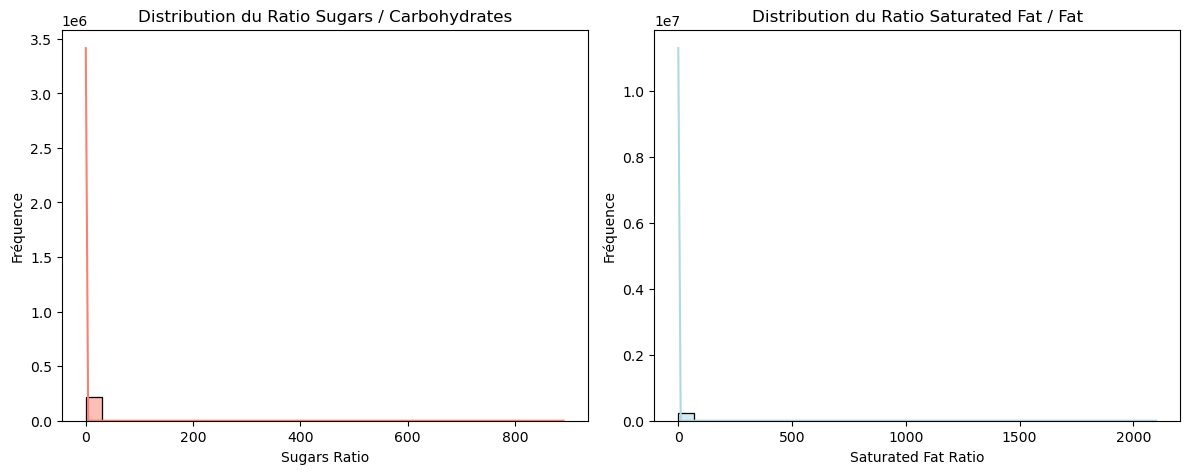

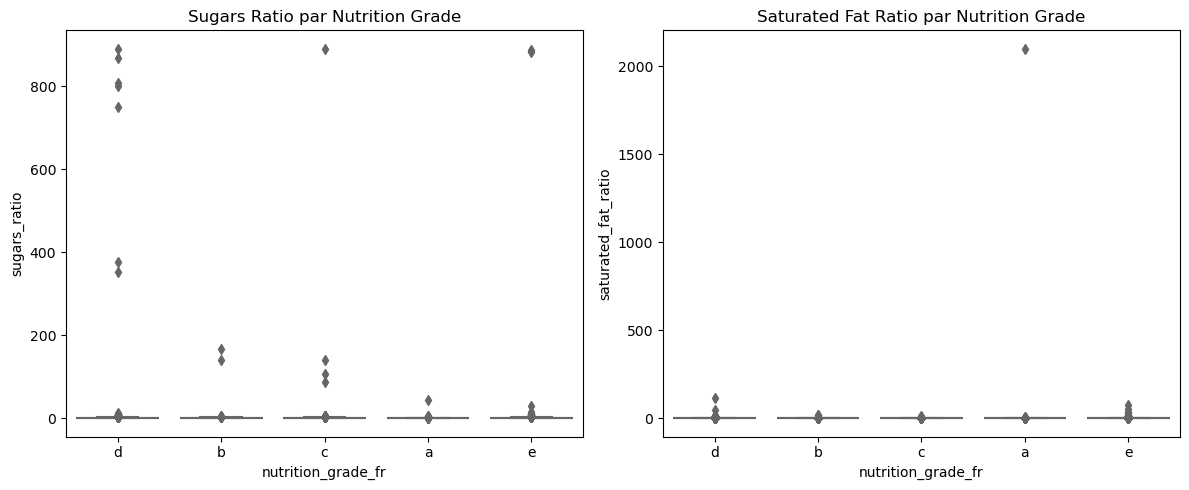

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1Ô∏è‚É£ Chargement du DataFrame transform√©
X_clean = pd.read_csv('X_clean_transformed.csv')

# 2Ô∏è‚É£ Visualisation de la distribution des ratios
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(X_clean['sugars_ratio'], bins=30, kde=True, color='salmon')
plt.title("Distribution du Ratio Sugars / Carbohydrates")
plt.xlabel("Sugars Ratio")
plt.ylabel("Fr√©quence")

plt.subplot(1, 2, 2)
sns.histplot(X_clean['saturated_fat_ratio'], bins=30, kde=True, color='lightblue')
plt.title("Distribution du Ratio Saturated Fat / Fat")
plt.xlabel("Saturated Fat Ratio")
plt.ylabel("Fr√©quence")

plt.tight_layout()
plt.show()

# 3Ô∏è‚É£ Visualisation par nutrition_grade_fr
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x=X_clean['nutrition_grade_fr'], y=X_clean['sugars_ratio'], palette='Set3')
plt.title("Sugars Ratio par Nutrition Grade")

plt.subplot(1, 2, 2)
sns.boxplot(x=X_clean['nutrition_grade_fr'], y=X_clean['saturated_fat_ratio'], palette='Set3')
plt.title("Saturated Fat Ratio par Nutrition Grade")

plt.tight_layout()
plt.show()

On voit clairement que certaines variables sont presque redondantes, et des optimisations peuvent √™tre faites.

Les ratios cr√©√©s pr√©c√©demment devraient nous aider √† mieux capter l'impact relatif de certaines composantes (gras/satur√©, sucres/glucides).

1Ô∏è_ Corr√©lations fortes identifi√©es :

fat_100g ‚Üî saturated-fat_100g : Ce lien est attendu puisque les graisses satur√©es font partie des graisses totales. Cette redondance pourrait permettre de r√©duire l'information en ne conservant qu'une des deux, ou alors de cr√©er un ratio (ce que nous avons d√©j√† fait avec saturated_fat_ratio).

salt_100g ‚Üî sodium_100g : Corr√©lation presque parfaite, ce qui est logique √©tant donn√© que le sel est majoritairement compos√© de sodium. Nous avons supprim√© cette redondance.

carbohydrates_100g ‚Üî sugars_100g : Les sucres sont inclus dans les glucides, donc cette corr√©lation est naturelle.

ingredients_that_may_be_from_palm_oil_n ‚Üî ingredients_from_palm_oil_n : Cette corr√©lation indique que lorsque l'un est pr√©sent, l'autre l'est souvent aussi.

2Ô∏è_ Variables influen√ßant les scores nutritionnels :

Les scores nutritionnels FR et UK sont impact√©s par :

Les graisses totales et les graisses satur√©es ‚Üí Plus elles sont √©lev√©es, plus le score est mauvais.

Les sucres ‚Üí Une quantit√© √©lev√©e de sucre influe √©galement n√©gativement.

Les fibres ‚Üí Influence positive (r√©duit le score).

L'√©nergie ‚Üí Plus le produit est calorique, plus le score peut √™tre mauvais.

MACHINE LEARNING

üîÑ Chargement du DataFrame nettoy√©...


/tmp/ipykernel_1541/2441981688.py:8: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  X_clean = pd.read_csv('X_clean_transformed.csv')


‚úÖ Dimensions de X_clean : (221210, 34)

üóëÔ∏è Suppression des redondances suppl√©mentaires...
‚úÖ Colonnes supprim√©es : ['sugars_100g', 'saturated-fat_100g']

üìä Visualisation des distributions finales...


/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na opti

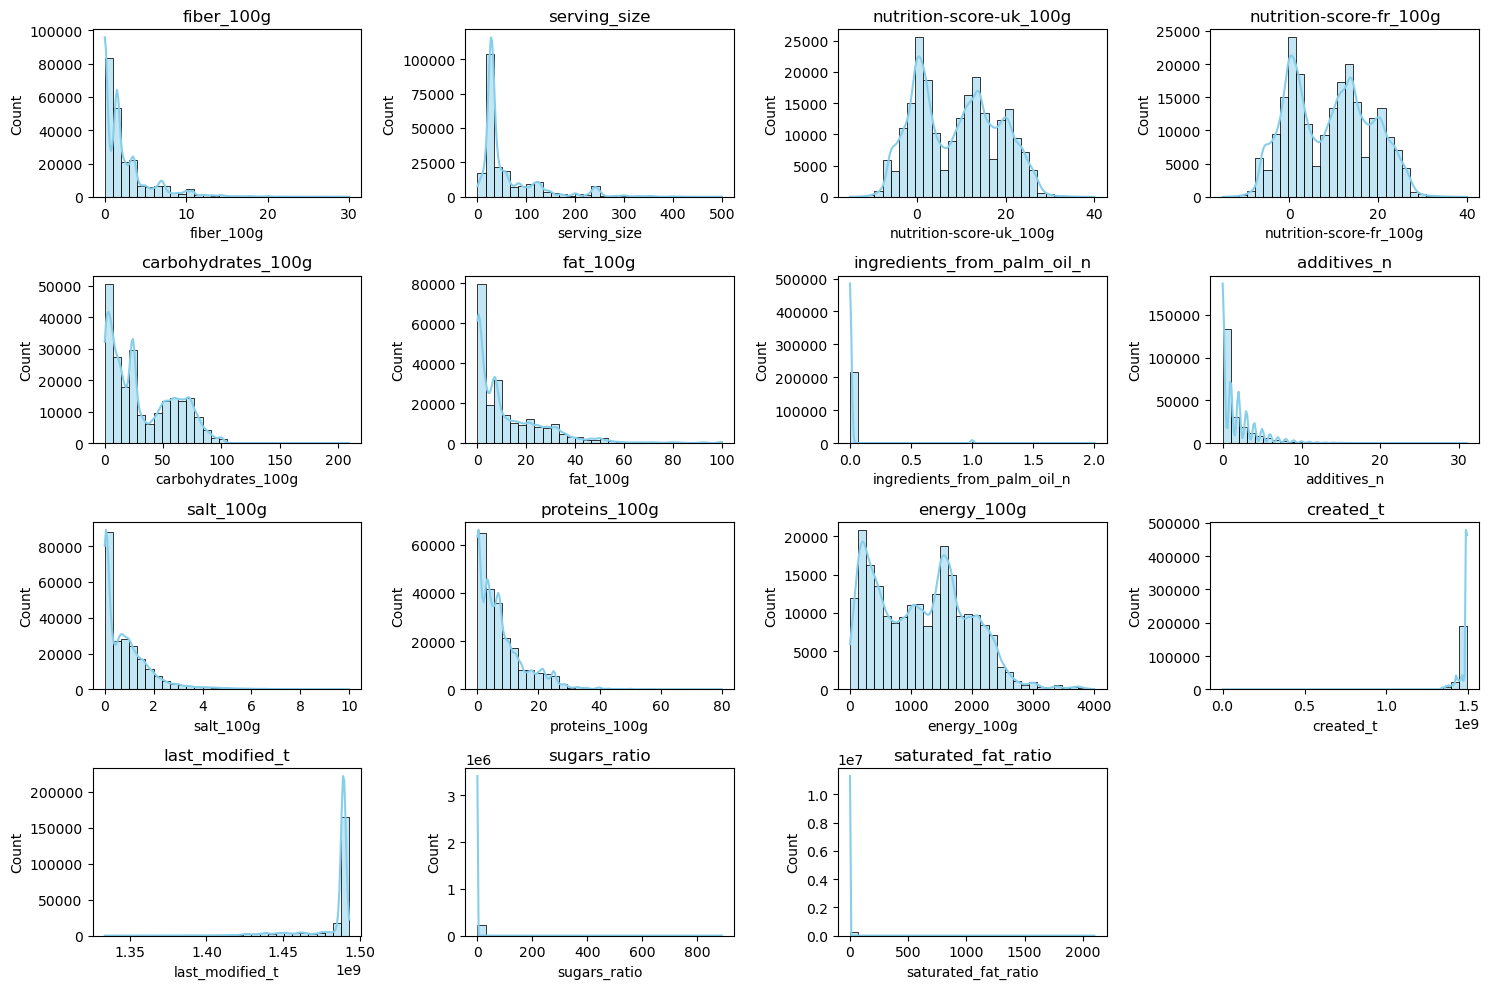


üöÄ Pr√©paration pour le Machine Learning...

üîÑ Encodage des variables qualitatives...


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1Ô∏è‚É£ Chargement du DataFrame nettoy√©
print("üîÑ Chargement du DataFrame nettoy√©...")
X_clean = pd.read_csv('X_clean_transformed.csv')
print(f"‚úÖ Dimensions de X_clean : {X_clean.shape}")

# 2Ô∏è‚É£ Suppression des redondances d√©tect√©es
print("\nüóëÔ∏è Suppression des redondances suppl√©mentaires...")
colonnes_a_supprimer = ['sugars_100g', 'saturated-fat_100g']
X_clean.drop(columns=colonnes_a_supprimer, inplace=True, errors='ignore')
print(f"‚úÖ Colonnes supprim√©es : {colonnes_a_supprimer}")

# 3Ô∏è‚É£ Visualisation des distributions
print("\nüìä Visualisation des distributions finales...")
variables_quantitatives = X_clean.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(15, 10))
for i, var in enumerate(variables_quantitatives):
    plt.subplot(4, 4, i + 1)
    sns.histplot(X_clean[var], bins=30, kde=True, color='skyblue')
    plt.title(var)
plt.tight_layout()
plt.show()

# 4Ô∏è‚É£ Pr√©paration pour le Machine Learning
print("\nüöÄ Pr√©paration pour le Machine Learning...")

# S√©paration des variables quantitatives et qualitatives
X_quant = X_clean.select_dtypes(include=[np.number])
X_qual = X_clean.select_dtypes(include=['object'])

# Encodage des variables qualitatives
print("\nüîÑ Encodage des variables qualitatives...")
X_qual_encoded = pd.get_dummies(X_qual, drop_first=True)

# Assemblage final du DataFrame pr√™t pour le ML
print("\nüîó Assemblage final des donn√©es...")
X_final = pd.concat([X_quant, X_qual_encoded], axis=1)
print(f"‚úÖ Dimensions apr√®s encodage : {X_final.shape}")

# 5Ô∏è‚É£ Sauvegarde du DataFrame final
X_final.to_csv('X_clean_ready_for_ml.csv', index=False)
print("\nüíæ Sauvegarde effectu√©e : 'X_clean_ready_for_ml.csv' est pr√™t pour le Machine Learning.")

RESUME:

1Ô∏è_ Chargement du DataFrame :

Lecture de X_clean_transformed.csv.

2Ô∏è_ Suppression des redondances suppl√©mentaires :

sugars_100g et saturated-fat_100g sont retir√©es car leurs ratios sont d√©j√† cr√©√©s.

3Ô∏è_ Visualisation des distributions finales :

Histogrammes pour observer les distributions des variables quantitatives.

4Ô∏è_ Pr√©paration pour le Machine Learning :

S√©paration des variables qualitatives et quantitatives.

Encodage des variables qualitatives avec One-Hot Encoding.

Assemblage final du DataFrame pour le Machine Learning.

5Ô∏è_ Sauvegarde du DataFrame :

Sauvegarde du dataset final sous le nom X_clean_ready_for_ml.csv.